In [1]:
# Two issues - Resolved!

# 1) Weird low-frequency artifacts when masking with square masks
# 2) Still missing the fainter points

# To remedy this, I'm going to try to look for bright spots in constrained areas
# Calculate lattice statistics on the new spots found (filtering out some of the spots under stringent criteria)
# But return the indices of all points picked up on the secondpass + firstpass for masking

# I'm also going to restructure find_lattice and the while loop in mask_image...it's a mess.

# Finally, I'm going to code a switch into mask_image to specify whether it's going to look for a lattice at all.

# So let's use this script to develop a new version of mask_image and find_lattice.

In [2]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdsec_opened
from itertools import product
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
import numpy as np
import scipy.fft as sfft
import matplotlib.pyplot as plt
import time
import multiprocessing
import os

In [4]:
# Add/Eliminate parameters from this list as needed

pixel_size = 1.048
threads=16
gaussian_smoothing=12
num_sd=4
x_window_fraction=(0.002, 0.95)
y_window_fraction=(0, 1)
look_for_lattice=True
min_lattice_size=3
epsilon=0.0707
num_sd_secondpass=2.5
box_radius=5
mask_along_lattice=True
replace_angle=15
return_spots=False
return_stats=False
return_fft=True
return_image=False
verbose=True
show_plots=True

filename = 'test_data/test_lattice.mrc'
filename_out = 'test_data/test_lattice_masked.mrc'

scipy_fft(): FFT performed in 95.83 milliseconds.


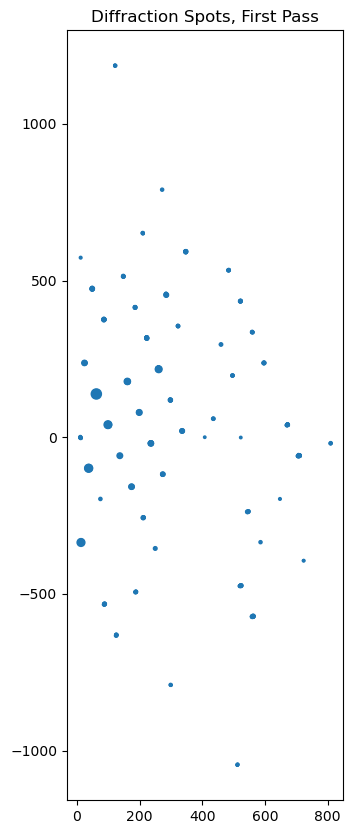

Starting basis: [[138 -99]
 [ 62  37]]
Starting basis size: 34058
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 135.31419624284092
[138  62] is larger than [-99  37]
The updated basis vectors are [39 99][-99  37]
This run resulted in a basis smaller than the last: 22492
The updated basis vectors are: [[ 39 -99]
 [ 99  37]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


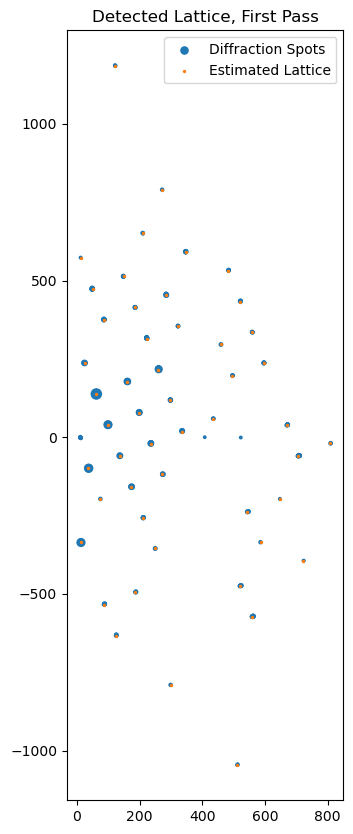

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.34386109 -98.78458808]
 [ 99.26131756  37.34255593]]
Unit cell dimensions (A): 56.53 57.16
Highest resolution spot (A): 5.06


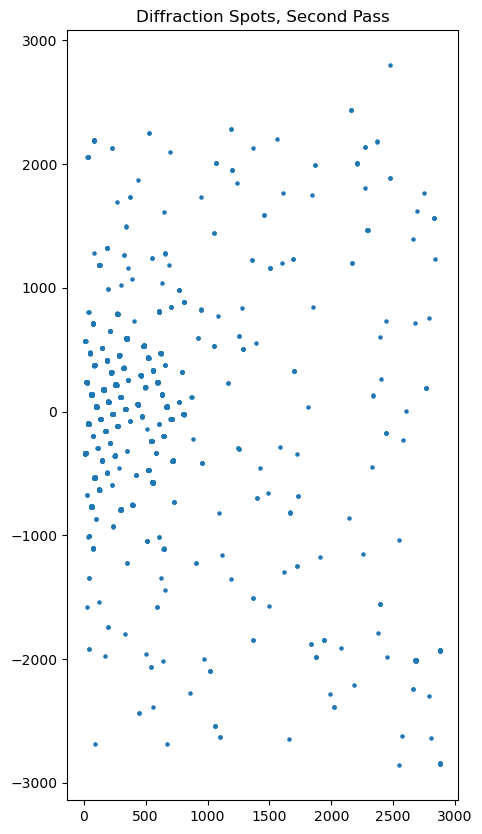

Starting basis: [[ 39 -99]
 [ 99  37]]
Starting basis size: 22492
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


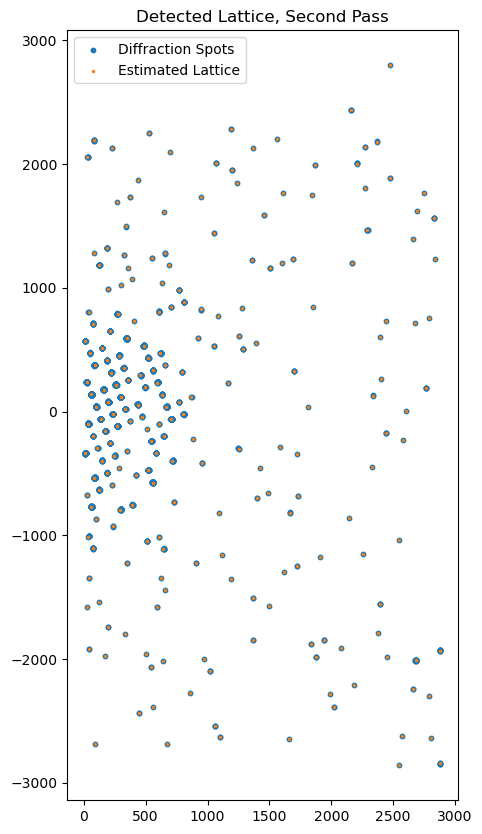

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.01484043 -98.95791685]
 [ 99.03178562  37.03277346]]
Unit cell dimensions (A): 56.71 57.13
Highest resolution spot (A): 1.49
scipy_ifft(): iFFT performed in 56.32 milliseconds.


In [16]:
masked_fft = sax.mask_image(filename=filename,
               filename_out=filename_out,
               pixel_size=pixel_size,
               threads=threads,
               gaussian_smoothing=gaussian_smoothing,
               num_sd=num_sd,
               x_window_fraction=x_window_fraction,
               y_window_fraction=y_window_fraction,
               look_for_lattice=look_for_lattice,
               min_lattice_size=min_lattice_size,
               epsilon=epsilon,
               num_sd_secondpass=num_sd_secondpass,
               box_radius=box_radius,
               mask_along_lattice=mask_along_lattice,
               replace_angle=replace_angle,
               return_spots=return_spots,
               return_stats=return_stats,
               return_fft=return_fft,
               return_image=return_image,
               verbose=verbose,
               show_plots=show_plots)

In [17]:
# Mask image

# Perform an FFT of the image
padded_fft = masked_fft

# Subtract the FFT from a Gaussian-smoothed FFT,
# Smooth again to distribute extremely high intensities to neighbouring points
# But save the original intensities for lattice weighting
log_diff_spectrum, smoothed_spectrum, amplitude_spectrum = sax.generate_diff_spectrum(padded_fft, gaussian_smoothing)

# Find spots that exceed the threshold
indices, amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, amplitude_spectrum, 3, x_window_fraction, y_window_fraction)

In [18]:
image, header = sax.import_mrc(filename)

# Replace the diffraction spots
masked_fft = sax.replace_diffraction_spots(padded_fft, indices, replace_angle)
# Perform the inverse FFT
padded_masked_image = sax.scipy_inverse_fft(masked_fft, verbose, threads)
# Extract the original image from the padded inverse FFT
masked_image = sax.unpad_image(padded_masked_image, image.shape)

sax.export_masked_mrc(masked_image, "test_data/test_lattice_double.mrc", verbose)

scipy_ifft(): iFFT performed in 69.63 milliseconds.
Export complete!
